In [1]:
from source.ion_channel import IonChannel
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras



/Users/mohamad/PycharmProjects/MastersThesis/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Produce some data

In [2]:
X = []
y = []
for i in range(1500):
    channel = IonChannel(1000)
    X.append(channel.X)
    y.append(channel.y)

In [3]:
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(1500, 1000)
(1500, 1000)


In [4]:
X_train = X[:1000]
y_train = y[:1000]
X_test = X[1000:]
y_test = y[1000:]

In [8]:
# prepare data for LSTM, X is 100 points and y is 1 point
def prepare_data(X, y, x_len=50, y_len=1, n_samples=1000):
    X_lstm = []
    y_lstm = []
    for i in range(n_samples):
        # randomly select a datapoint in X and y
        idx = np.random.randint(0, len(X) - x_len - y_len)
        # randomly select a point in X[idx] which its index is greater than x_len and smaller than len(X[idx]) - x_len
        y_index = np.random.randint(x_len, len(X[idx]) - x_len)
        y_lstm.append(y[idx][y_index:y_index + y_len])
        # x is the previous x_len points of y and x_len points after y, excluding y
        x_before = X[idx][y_index - x_len:y_index]
        x_after = X[idx][y_index + 1:y_index + x_len + 1]
        X_lstm.append(np.concatenate((x_before, x_after)))

    return np.array(X_lstm), np.array(y_lstm)


In [9]:
X_train_lstm, y_train_lstm = prepare_data(X_train, y_train)
X_test_lstm, y_test_lstm = prepare_data(X_test, y_test)

In [10]:
print(X_train_lstm.shape)
print(y_train_lstm.shape)

(1000, 100)
(1000, 1)


## Build a model

In [11]:
# y is either 0 or 1. shape of X_train_lstm is (1000, 100), shape of y_train_lstm is (1000, 1)
model = keras.Sequential([
    keras.layers.LSTM(100, input_shape=(100, 1)),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(X_train_lstm, y_train_lstm, epochs=100, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/100
32/32 [==============================] - 2s 42ms/step - loss: 0.6852 - accuracy: 0.5320 - val_loss: 0.6806 - val_accuracy: 0.5300
Epoch 2/100
32/32 [==============================] - 1s 36ms/step - loss: 0.6764 - accuracy: 0.5550 - val_loss: 0.7004 - val_accuracy: 0.4700
Epoch 3/100
32/32 [==============================] - 1s 37ms/step - loss: 0.6861 - accuracy: 0.5480 - val_loss: 0.6810 - val_accuracy: 0.5300
Epoch 4/100
32/32 [==============================] - 1s 37ms/step - loss: 0.6774 - accuracy: 0.5400 - val_loss: 0.6504 - val_accuracy: 0.5300
Epoch 5/100
32/32 [==============================] - 1s 38ms/step - loss: 0.6171 - accuracy: 0.6740 - val_loss: 0.5855 - val_accuracy: 0.7270
Epoch 6/100
32/32 [==============================] - 1s 38ms/step - loss: 0.5508 - accuracy: 0.7410 - val_loss: 0.8161 - val_accuracy: 0.7040
Epoch 7/100
32/32 [==============================] - 1s 36ms/step - loss: 0.5924 - accuracy: 0.7490 - val_loss: 0.4909 - val_accuracy: 0.7850
Epoch 

## Test the model

In [13]:
y_pred = model.predict(X_test_lstm)
# round the prediction to 0 or 1
y_pred = np.round(y_pred)

32/32 [==============================] - 0s 10ms/step


In [14]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_lstm, y_pred)

0.955

In [47]:
def prepare_test_data(X, y, x_len=50, y_len=1):
    X_lstm = []
    y_lstm = []
    for i in range(len(X)):
        for j in range(x_len, len(X[i]) - x_len):
            idx = i
            # randomly select a point in X[idx] which its index is greater than x_len and smaller than len(X[idx]) - x_len
            y_index = j
            y_lstm.append(y[idx][y_index:y_index + y_len])
            # x is the previous x_len points of y and x_len points after y, excluding y
            x_before = X[idx][y_index - x_len:y_index]
            x_after = X[idx][y_index + 1:y_index + x_len + 1]
            X_lstm.append(np.stack([np.concatenate((x_before, x_after))]))
            
    return np.array(X_lstm), np.array(y_lstm)
    

In [53]:
test_ion = IonChannel(1000)
X_test_ion = test_ion.X
y_test_ion = test_ion.y

X_test_ion_lstm, y_test_ion_lstm = prepare_test_data([X_test_ion], [y_test_ion])
print(X_test_ion_lstm.shape)
print(y_test_ion_lstm.shape)

(900, 1, 100)
(900, 1)


In [55]:
y_pred_ion = model.predict(X_test_ion_lstm.reshape(900, 100))
y_pred_ion = np.round(y_pred_ion)

29/29 [==============================] - 0s 10ms/step


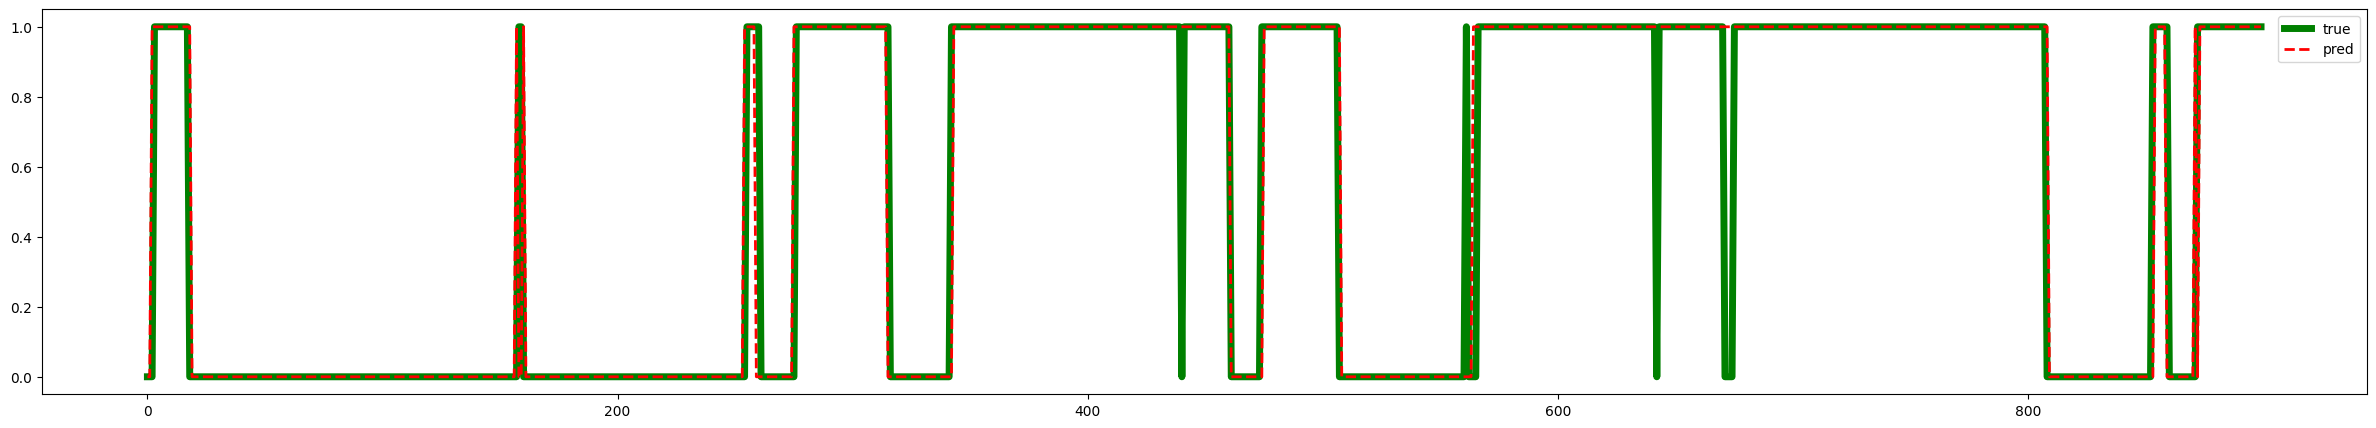

In [56]:
plt.figure(figsize=(30, 5))
plt.plot(y_test_ion_lstm, color='green', label='true', linestyle='solid', linewidth=5)
plt.plot(y_pred_ion, color='red', label='pred', linestyle='dashed', linewidth=2)
# X_test_ion scatter plot
# plt.scatter(range(len(X_test_ion)), X_test_ion, color='green', label='true')
plt.legend()

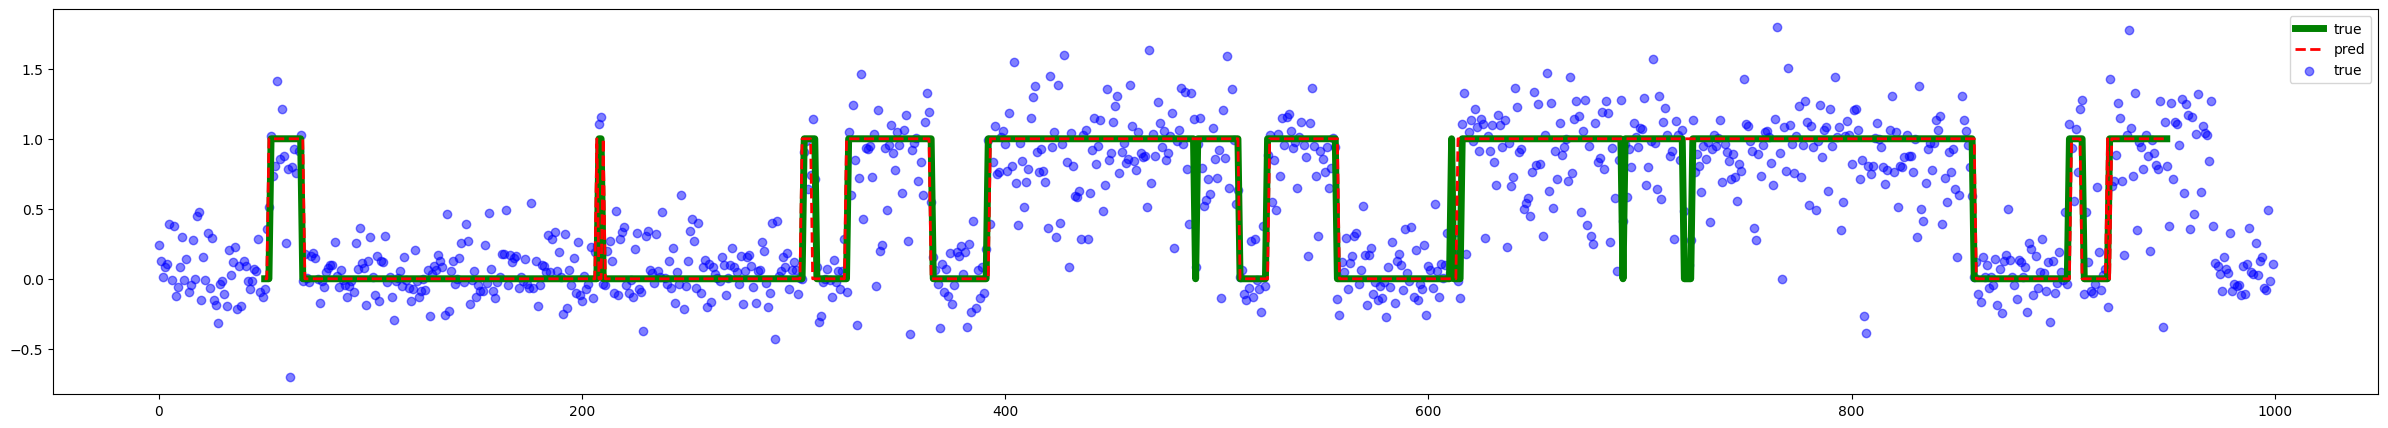

In [59]:
# normalize X_test_ion to be between 2 and 0
X_test_ion = (X_test_ion - np.min(X_test_ion)) / (np.max(X_test_ion) - np.min(X_test_ion)) * 2.5 - 0.7

plt.figure(figsize=(30, 5))
# start from 50
plt.plot(range(50, 50 + len(y_test_ion_lstm)), y_test_ion_lstm, color='green', label='true', linestyle='solid',
         linewidth=5)
# start from 50
plt.plot(range(50, 50 + len(y_pred_ion)), y_pred_ion, color='red', label='pred', linestyle='dashed', linewidth=2)
# X_test_ion scatter plot
plt.scatter(range(len(X_test_ion)), X_test_ion, color='blue', label='true', alpha=0.5)
plt.legend()